<a href="https://colab.research.google.com/github/gravity0717/Capstone/blob/main/MuitiCNN_MU_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd 
import json 
import tarfile 
import torch 
from torch.utils.data import Dataset
import math
from PIL import Image
from google.colab import drive 
drive.mount('/content/drive')
import math

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.metrics import mean_squared_error
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(970717)

**데이터 정의**

1.MU

2.MU-normalize : groundtruth 를 0 to 1 으로 정규화


In [ ]:
from PIL import Image 
import glob
from torch.utils.data.dataset import Dataset
import numpy as np 
from torchvision import transforms
import os 
class MU(Dataset):
  def __init__(self,csv_path):
    self.to_tensor=transforms.ToTensor()
    # Read the csv file 
    self.data_info = pd.read_csv(csv_path,header=None)
    # Read image path 
    self.img_path =  np.asarray(self.data_info.iloc[1:,8])
    # Read the log_view < log_view as label>
    self.label_arr =np.asarray(self.data_info.iloc[1:,7])
    
    
    #data augmentation 을 기대할 수 있는 부분 ???! 고민해보자 
    self.transformations = \
            transforms.Compose([transforms.Resize(256),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.ToTensor()])
    
  
        
  def __len__(self):
    return len(self.label_arr)
  # def wait to drop 

  def __getitem__(self,idx):
   #Get image name (actually path where images are )from pandas 
    if self.img_path is not np.nan:
      u=self.img_path[idx] + "/u" # 상의
      p=self.img_path[idx] + "/p" # 하의
      s=self.img_path[idx] + "/s" # 상의
    else: 
      pass 
    # Open Image 
    # 이미지가 경로에 없는 겨우 대비해야 할 것 
    if os.path.isfile(u):
      u_as_img =Image.open(u)
    else :
      u_as_img =Image.new("RGB", (256, 256), (255, 255, 255))
    if os.path.isfile(p):
      p_as_img =Image.open(p)
    else :
      p_as_img =Image.new("RGB", (256, 256), (255, 255, 255))

    if os.path.isfile(s):
      s_as_img =Image.open(s)
    else :
      s_as_img =Image.new("RGB", (256, 256), (255, 255, 255))
    #Img -> to tensor 
    u_as_tensor =self.to_tensor(u_as_img)
    p_as_tensor =self.to_tensor(p_as_img)
    s_as_tensor =self.to_tensor(s_as_img)
    

    _label=torch.tensor(float(self.label_arr[idx]))
    label=torch.reshape(_label,(-1,))
 
    
    return(u_as_tensor,p_as_tensor,s_as_tensor,label )



In [ ]:
from PIL import Image 
import glob
from torch.utils.data.dataset import Dataset
import numpy as np 
from torchvision import transforms
from sklearn.preprocessing import minmax_scale
import os 
class MU_normalized(Dataset):
  def __init__(self,csv_path):
    self.to_tensor=transforms.ToTensor()
    # Read the csv file 
    self.data_info = pd.read_csv(csv_path,header=None)
    # Read image path 
    self.img_path =  np.asarray(self.data_info.iloc[1:,8])
    # Read the log_view < log_view as label>
    self.label_arr =np.asarray(self.data_info.iloc[1:,7])
    self.label_arr=minmax_scale(self.label_arr)
    print(self.label_arr)
    
    #data augmentation 을 기대할 수 있는 부분 ???! 고민해보자 
    self.transformations = \
            transforms.Compose([transforms.Resize((256,256)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.ToTensor()])
    
  
        
  def __len__(self):
    return len(self.label_arr)
  # def wait to drop 

  def __getitem__(self,idx):
   #Get image name (actually path where images are )from pandas 
    if self.img_path is not np.nan:
      u=self.img_path[idx] + "/u" # 상의
      p=self.img_path[idx] + "/p" # 하의
      s=self.img_path[idx] + "/s" # 상의
    else: 
      pass 
    # Open Image 
    # 이미지가 경로에 없는 겨우 대비해야 할 것 
    if os.path.isfile(u):
      u_as_img =Image.open(u)
    else :
      u_as_img =Image.new("RGB", (256, 256), (255, 255, 255))
    if os.path.isfile(p):
      p_as_img =Image.open(p)
    else :
      p_as_img =Image.new("RGB", (256, 256), (255, 255, 255))

    if os.path.isfile(s):
      s_as_img =Image.open(s)
    else :
      s_as_img =Image.new("RGB", (256, 256), (255, 255, 255))
    #Img -> to tensor 
    u_as_tensor =self.to_tensor(u_as_img)
    p_as_tensor =self.to_tensor(p_as_img)
    s_as_tensor =self.to_tensor(s_as_img)
    

    _label=torch.tensor(float(self.label_arr[idx]))
    label=torch.reshape(_label,(-1,))
 
    
    return(u_as_tensor,p_as_tensor,s_as_tensor,label)



**Model Architecture**

1. VGG16 transfer learning

2. Model_dp : model with dropout

3. Model_no_dp : model without dropout

In [ ]:
'''

transfer learning 


새로 훈련할 데이터가 적지만 original 데이터와 유사할 경우
데이터의 양이 적어 fine-tune (전체 모델에 대해서 backpropagation을 진행하는 것) 은 over-fitting의 위험이 있기에 하지 않습니다.
새로 학습할 데이터는 original 데이터와 유사하기 때문에 이 경우 최종 linear classfier 레이어만 학습을 합니다.

새로 훈련할 데이터가 매우 많으며 original 데이터와 유사할 경우
새로 학습할 데이터의 양이 많다는 것은 over-fitting의 위험이 낮다는 뜻이므로, 전체 레이어에 대해서 fine-tune을 합니다.

새로 훈련할 데이터가 적으며 original 데이터와 다른 경우
데이터의 양이 적기 때문에 최종 단계의 linear classifier 레이어를 학습하는 것이 좋을 것입니다. 반면서 데이터가 서로 다르기 때문에 거의 마지막부분 (the top of the network)만 학습하는 것은 좋지 않습니다. 서로 상충이 되는데.. 이 경우에는 네트워크 초기 부분 어딘가 activation 이후에 특정 레이어를 학습시키는게 좋습니다.

새로 훈련할 데이터가 많지만 original 데이터와와 다른 경우
데이터가 많기 때문에 아예 새로운 ConvNet을 만들수도 있지만, 실적적으로 transfer learning이 더 효율이 좋습니다. 전체 네트워크에 대해서 fine-tune을 해도 됩니다.

'''

from torchvision import models

model_pt=models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')


for p in model_pt.parameters():
  p.requires_grad=False # 가중치가 학습되지 않도록 함 
#in_features?


print(model_pt.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:

'''
pretrained model VGG 16 AlexNet LeNet .... Transfer learning 
'''
import torch.nn.functional as F
from torch import nn
class Model_dp(nn.Module):
    def __init__(self):
        super(Model_dp, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.l1   =  nn.Linear(98304 ,1024)
        self.l2   =  nn.Linear(1024,1) # regression 이기 때문에 마지막 차원 1 
        self.VGG16 = model_pt.features
        self.dp   = nn.Dropout(p=0.5)
    def forward(self, top ,bot,shoes):
        top= self.VGG16(top)   #256*256
        bot = self.VGG16(bot)  
        shoes = self.VGG16(shoes) 
        N ,_,_,_ = top.size()

        top = top.reshape(N,-1)
        bot = bot.reshape(N,-1)
        shoes = shoes.reshape(N,-1)
        z = torch.cat((top,bot,shoes),1)
        z = self.l1(z)
        z = self.relu(z)
        z = self.dp(z)
        z = self.l2(z)
        return z
    


In [ ]:

'''
pretrained model VGG 16 AlexNet LeNet .... Transfer learning 
'''
import torch.nn.functional as F
from torch import nn
class Model_no_dp(nn.Module):
    def __init__(self):
        super(Model_no_dp, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.l1   =  nn.Linear(98304 ,1024)
        self.l2   =  nn.Linear(1024,1) # regression 이기 때문에 마지막 차원 1 
        self.VGG16 = model_pt.features
        self.dp   = nn.Dropout(p=0.5)
    def forward(self, top ,bot,shoes):
        top= self.VGG16(top)   #256*256
        bot = self.VGG16(bot)  
        shoes = self.VGG16(shoes) 
        N ,_,_,_ = top.size()

        top = top.reshape(N,-1)
        bot = bot.reshape(N,-1)
        shoes = shoes.reshape(N,-1)
        z = torch.cat((top,bot,shoes),1)
        z = self.l1(z)
        z = self.relu(z)
        z = self.l2(z)
        return z
    


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/캡스톤/label_and_path_withoutNaN")
df.iloc[:,7]

0       8.139149
1       7.519692
2       5.913503
3       7.142827
4       5.777652
          ...   
3911    7.311218
3912    7.476472
3913    6.815640
3914    7.043160
3915    5.081404
Name: log-view, Length: 3916, dtype: float64

**Train / Test 정의**

In [ ]:

def train(n_epochs,model, optimizer,criterion):

  rmse_train_history = []
  for epoch in range(1, n_epochs + 1):

    dataiter=iter(train_dataloader)
    u,p,s ,label = dataiter.next()
        # clearing the Gradients of the model parameters
    optimizer.zero_grad()

        # prediction for training and validation set
    model.train()
    u=u.type(torch.cuda.FloatTensor)
    p=p.type(torch.cuda.FloatTensor)
    s=s.type(torch.cuda.FloatTensor)
    label=label.to(device)
    output_train = model(u,p,s)
        
        # computing the training and validation loss
    train_rmse = torch.sqrt(criterion(output_train, label)) #RMSE
    train_rmse.backward()
    optimizer.step()
    if epoch % 10== 0:
      print('Epoch :', epoch, '\t', 'RMSE', round(train_rmse.item(), 3))
    rmse_train_history.append(train_rmse)
  return rmse_train_history

def test(n_epochs,model, optimizer,criterion):
  rmse_history = []
  for epoch in range(1, n_epochs + 1):
    model.eval()
    testiter=iter(test_dataloader)
    u,p,s ,y_test=testiter.next()
    y_test=y_test.detach().cpu().numpy()    
    u=u.type(torch.cuda.FloatTensor)
    p=p.type(torch.cuda.FloatTensor)
    s=s.type(torch.cuda.FloatTensor)   
           # prediction on testing dataset
    pred = model(u,p,s)
    pred=pred.detach().cpu().numpy()
    test_rmse = math.sqrt(mean_squared_error(y_test,pred))
    if epoch % 10== 0:
      print('Epoch :', epoch, '\t',"RMSE =", round(test_rmse,3))
    rmse_history.append(test_rmse)
  return rmse_history

**학습**


In [ ]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split


custom_cloth = MU("/content/drive/MyDrive/캡스톤/label_and_path_withoutNaN")
    # Define dataloader

dataset_size = len(custom_cloth)
train_size = int(dataset_size * 0.8)

test_size = dataset_size - train_size

train_dataset,  test_dataset = random_split(custom_cloth, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)


In [ ]:
custom_cloth = MU_normalized("/content/drive/MyDrive/캡스톤/label_and_path_withoutNaN")
dataset_size = len(custom_cloth)

train_dataset,  test_dataset = random_split(custom_cloth, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)


[0.66100355 0.56506451 0.31630399 ... 0.45602354 0.49126097 0.18743171]


In [ ]:
torch.manual_seed(999)
model_no_dp=Model_no_dp().to(device) 
dataset_size = len(custom_cloth)
train_dataset,  test_dataset = random_split(custom_cloth, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)
criterion =torch.nn.MSELoss()
optimizer =torch.optim.SGD(model_no_dp.parameters(), lr=  0.01)

train_li=train(500,model_no_dp,optimizer=optimizer,criterion=criterion)
test_li=test(500,model_no_dp,optimizer=optimizer,criterion=criterion)

Epoch : 290 	 RMSE 0.23
Epoch : 300 	 RMSE 0.117
Epoch : 310 	 RMSE 0.147
Epoch : 320 	 RMSE 0.087
Epoch : 330 	 RMSE 0.085
Epoch : 340 	 RMSE 0.116
Epoch : 350 	 RMSE 0.142
Epoch : 360 	 RMSE 0.173
Epoch : 370 	 RMSE 0.102
Epoch : 380 	 RMSE 0.129
Epoch : 390 	 RMSE 0.167
Epoch : 400 	 RMSE 0.124
Epoch : 410 	 RMSE 0.117
Epoch : 420 	 RMSE 0.155
Epoch : 430 	 RMSE 0.099
Epoch : 440 	 RMSE 0.083
Epoch : 450 	 RMSE 0.13
Epoch : 460 	 RMSE 0.126
Epoch : 470 	 RMSE 0.094
Epoch : 480 	 RMSE 0.126
Epoch : 490 	 RMSE 0.139
Epoch : 500 	 RMSE 0.139
Epoch : 10 	 RMSE = 0.276
Epoch : 20 	 RMSE = 0.14
Epoch : 30 	 RMSE = 0.14
Epoch : 40 	 RMSE = 0.087
Epoch : 50 	 RMSE = 0.039
Epoch : 60 	 RMSE = 0.192
Epoch : 70 	 RMSE = 0.105
Epoch : 80 	 RMSE = 0.225
Epoch : 90 	 RMSE = 0.068
Epoch : 100 	 RMSE = 0.148
Epoch : 110 	 RMSE = 0.088
Epoch : 120 	 RMSE = 0.07
Epoch : 130 	 RMSE = 0.165
Epoch : 140 	 RMSE = 0.066
Epoch : 150 	 RMSE = 0.069
Epoch : 160 	 RMSE = 0.185
Epoch : 170 	 RMSE = 0.161
Epoch

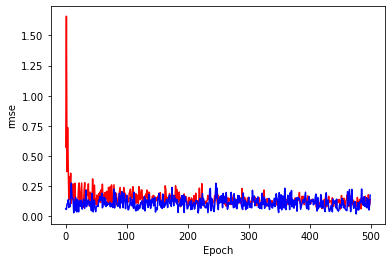

In [ ]:
#시각화
t_l=[]
for x in train_li:
  x=x.detach().cpu().numpy()
  t_l.append(x)
plt.plot(np.arange(500),t_l,'r')
plt.plot(np.arange(500),test_li,'b')

plt.xlabel("Epoch")
plt.ylabel("rmse")

plt.show()

In [ ]:

model_dp=Model_dp().to(device) 
criterion =torch.nn.MSELoss()
optimizer =torch.optim.SGD(model_dp.parameters(), lr=  0.01)
train_li=train(500,model_dp,optimizer=optimizer,criterion=criterion)
test_li=test(500,model_dp,optimizer=optimizer,criterion=criterion)

Epoch : 10 	 RMSE 0.163
Epoch : 20 	 RMSE 0.177
Epoch : 30 	 RMSE 0.143
Epoch : 40 	 RMSE 0.167
Epoch : 50 	 RMSE 0.131
Epoch : 60 	 RMSE 0.184
Epoch : 70 	 RMSE 0.224
Epoch : 80 	 RMSE 0.121
Epoch : 90 	 RMSE 0.243
Epoch : 100 	 RMSE 0.225
Epoch : 110 	 RMSE 0.182
Epoch : 120 	 RMSE 0.186
Epoch : 130 	 RMSE 0.132
Epoch : 140 	 RMSE 0.188
Epoch : 150 	 RMSE 0.152
Epoch : 160 	 RMSE 0.144
Epoch : 170 	 RMSE 0.241
Epoch : 180 	 RMSE 0.101
Epoch : 190 	 RMSE 0.119
Epoch : 200 	 RMSE 0.099
Epoch : 210 	 RMSE 0.155
Epoch : 220 	 RMSE 0.079
Epoch : 230 	 RMSE 0.144
Epoch : 240 	 RMSE 0.14
Epoch : 250 	 RMSE 0.128
Epoch : 260 	 RMSE 0.098
Epoch : 270 	 RMSE 0.158
Epoch : 280 	 RMSE 0.116
Epoch : 290 	 RMSE 0.093
Epoch : 300 	 RMSE 0.111
Epoch : 310 	 RMSE 0.083
Epoch : 320 	 RMSE 0.155
Epoch : 330 	 RMSE 0.118
Epoch : 340 	 RMSE 0.141
Epoch : 350 	 RMSE 0.116
Epoch : 360 	 RMSE 0.104
Epoch : 370 	 RMSE 0.178
Epoch : 380 	 RMSE 0.116
Epoch : 390 	 RMSE 0.125
Epoch : 400 	 RMSE 0.113
Epoch : 41

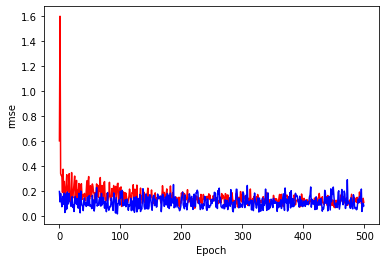

In [ ]:
#시각화
t_l=[]
for x in train_li:
  x=x.detach().cpu().numpy()
  t_l.append(x)
plt.plot(np.arange(500),t_l,'r')
plt.plot(np.arange(500),test_li,'b')

plt.xlabel("Epoch")
plt.ylabel("rmse")

plt.show()